# Progressive Overload Analysis

Analyzes workout data from the Strong app to track progressive overload across exercises.

## Data Pipeline
1. Discovers the latest `strong_workouts*.csv` in Downloads (sorted by file modification time)
2. Copies to `data/strong_workouts_YYYYMMDD.csv` for reproducibility
3. Filters to workouts from 2026 onward

## Progression Logic
Each set is compared to the corresponding set from the **most recent session** of that exercise:
- **Progressed**: Weight increased, or weight same and reps increased
- **Regressed**: Weight decreased, or weight same and reps decreased
- **Neutral**: No change, first time doing exercise, or mixed results across sets

Exercise-level progression aggregates set results: progressed if any set progressed (none regressed), regressed if any set regressed (none progressed), neutral otherwise.

## Visualizations
1. **Overview heatmap**: All workouts with exercise-level progression (green/yellow/red)
2. **Session detail**: Drill into a specific workout showing set-level weight x reps with comparison to previous session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime
import os
import shutil
from pathlib import Path

In [2]:
# Discover and copy latest Strong workout data from Downloads
downloads_dir = Path.home() / 'Downloads'

# Find all strong_workouts CSVs in Downloads
strong_files = list(downloads_dir.glob('*strong_workouts*.csv'))

if not strong_files:
    raise FileNotFoundError("No strong_workouts CSV files found in Downloads")

# Sort by modification time (most recent first)
strong_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
latest_file = strong_files[0]

# Get modification date for the filename
mtime = datetime.fromtimestamp(latest_file.stat().st_mtime)
date_str = mtime.strftime('%Y%m%d')

print(f"Found {len(strong_files)} strong_workouts file(s) in Downloads")
print(f"Latest: {latest_file.name}")
print(f"Modified: {mtime.strftime('%Y-%m-%d %H:%M:%S')}")

# Copy to data directory with date suffix
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

target_file = data_dir / f'strong_workouts_{date_str}.csv'

# Copy the file
shutil.copy2(latest_file, target_file)
print(f"\nCopied to: {target_file}")

# Store path for loading in next cell
WORKOUT_DATA_PATH = target_file

Found 1 strong_workouts file(s) in Downloads
Latest: strong_workouts.csv
Modified: 2026-01-27 07:07:36

Copied to: data/strong_workouts_20260127.csv


In [3]:
df = pd.read_csv(WORKOUT_DATA_PATH)
df['Date'] = pd.to_datetime(df['Date'])

CUTOFF_DATE = '2026-01-01'
df = df[df['Date'] >= CUTOFF_DATE].copy()

df['Week'] = df['Date'].dt.isocalendar().week
df['Year'] = df['Date'].dt.year
df['WeekStart'] = df['Date'].dt.to_period('W').apply(lambda x: x.start_time)

print(f"Records from 2026: {len(df):,}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

df.head()

Records from 2026: 212
Date range: 2026-01-02 14:31:53 to 2026-01-26 17:43:42


,Date,Workout Name,Duration,Exercise Name,Set Order,Weight,Reps,Distance,Seconds,RPE,Week,Year,WeekStart
10229,2026-01-02 14:31:53,Full Body,1h 15m,Hack Squat,1,250.0,8.0,0,0.0,NaN,1,2026,2025-12-29
10230,2026-01-02 14:31:53,Full Body,1h 15m,Hack Squat,2,250.0,8.0,0,0.0,NaN,1,2026,2025-12-29
10231,2026-01-02 14:31:53,Full Body,1h 15m,Shoulder Press (Plate Loaded),1,180.0,8.0,0,0.0,NaN,1,2026,2025-12-29
10232,2026-01-02 14:31:53,Full Body,1h 15m,Shoulder Press (Plate Loaded),2,180.0,6.0,0,0.0,NaN,1,2026,2025-12-29
10233,2026-01-02 14:31:53,Full Body,1h 15m,Shoulder Press (Plate Loaded),3,180.0,7.0,0,0.0,NaN,1,2026,2025-12-29


In [4]:
def compare_set(current_weight, current_reps, prev_weight, prev_reps):
    """
    Compare a set to the corresponding set from the previous week.
    
    Returns
    -------
    str
        'progressed', 'regressed', or 'neutral'
    """
    if pd.isna(prev_weight) or pd.isna(prev_reps):
        return 'neutral'
    
    if current_weight > prev_weight:
        return 'progressed'
    elif current_weight < prev_weight:
        return 'regressed'
    else:  # weight stayed same
        if current_reps > prev_reps:
            return 'progressed'
        elif current_reps < prev_reps:
            return 'regressed'
        else:
            return 'neutral'


def aggregate_exercise_progression(set_results):
    """
    Aggregate set-level results to exercise-level.
    
    - Progressed: all sets progressed/neutral, at least one progressed
    - Regressed: all sets regressed/neutral, at least one regressed
    - Neutral: all neutral, or mixed (some progressed, some regressed)
    """
    has_progressed = 'progressed' in set_results
    has_regressed = 'regressed' in set_results
    
    if has_progressed and has_regressed:
        return 'neutral'
    elif has_progressed:
        return 'progressed'
    elif has_regressed:
        return 'regressed'
    else:
        return 'neutral'

In [5]:
# Build a lookup of sets by (Date, Exercise Name, Set Order) -> (Weight, Reps)
set_lookup = df.groupby(['Date', 'Exercise Name', 'Set Order']).agg({
    'Weight': 'first',
    'Reps': 'first'
}).to_dict('index')

# For each exercise, get sorted list of dates it was performed
exercise_dates = df.groupby('Exercise Name')['Date'].apply(lambda x: sorted(x.unique())).to_dict()

def get_prev_date_for_exercise(exercise: str, current_date) -> pd.Timestamp:
    """Get the most recent date this exercise was performed before current_date."""
    dates = exercise_dates.get(exercise, [])
    prev_dates = [d for d in dates if d < current_date]
    return prev_dates[-1] if prev_dates else None

print(f"Unique exercises: {len(exercise_dates)}")
print(f"Total set records: {len(set_lookup)}")

Unique exercises: 24
Total set records: 212


In [6]:
# Calculate progression for each set
def get_set_progression(row):
    current_date = row['Date']
    exercise = row['Exercise Name']
    set_order = row['Set Order']
    
    prev_date = get_prev_date_for_exercise(exercise, current_date)
    if prev_date is None:
        return 'neutral'  # First time doing this exercise
    
    prev_key = (prev_date, exercise, set_order)
    if prev_key not in set_lookup:
        return 'neutral'  # No corresponding set last time
    
    prev_data = set_lookup[prev_key]
    return compare_set(
        row['Weight'], row['Reps'],
        prev_data['Weight'], prev_data['Reps']
    )

df['SetProgression'] = df.apply(get_set_progression, axis=1)
df[['Date', 'Exercise Name', 'Set Order', 'Weight', 'Reps', 'SetProgression']].head(20)

,Date,Exercise Name,Set Order,Weight,Reps,SetProgression
10229,2026-01-02 14:31:53,Hack Squat,1,250.0,8.0,neutral
10230,2026-01-02 14:31:53,Hack Squat,2,250.0,8.0,neutral
10231,2026-01-02 14:31:53,Shoulder Press (Plate Loaded),1,180.0,8.0,neutral
10232,2026-01-02 14:31:53,Shoulder Press (Plate Loaded),2,180.0,6.0,neutral
10233,2026-01-02 14:31:53,Shoulder Press (Plate Loaded),3,180.0,7.0,neutral
10234,2026-01-02 14:31:53,Lat Pulldown (Cable),1,180.0,8.0,neutral
10235,2026-01-02 14:31:53,Lat Pulldown (Cable),2,180.0,8.0,neutral
10236,2026-01-02 14:31:53,Lat Pulldown (Cable),3,180.0,8.0,neutral
10237,2026-01-02 14:31:53,Back Extension,1,100.0,12.0,neutral
10238,2026-01-02 14:31:53,Back Extension,2,100.0,12.0,neutral


In [7]:
# Aggregate to exercise level per workout
exercise_progression = df.groupby(['Date', 'Workout Name', 'Exercise Name']).agg({
    'SetProgression': lambda x: aggregate_exercise_progression(list(x)),
    'Weight': 'max',
    'Reps': 'sum'
}).reset_index()
exercise_progression.columns = ['Date', 'Workout Name', 'Exercise Name', 'Progression', 'MaxWeight', 'TotalReps']
exercise_progression

,Date,Workout Name,Exercise Name,Progression,MaxWeight,TotalReps
0,2026-01-02 14:31:53,Full Body,Back Extension,neutral,100.0,36.0
1,2026-01-02 14:31:53,Full Body,Hack Squat,neutral,250.0,16.0
2,2026-01-02 14:31:53,Full Body,Lat Pulldown (Cable),neutral,180.0,24.0
3,2026-01-02 14:31:53,Full Body,Lateral Raise (Cable),neutral,41.0,29.0
4,2026-01-02 14:31:53,Full Body,Preacher Curl (Barbell),neutral,50.0,34.0
...,...,...,...,...,...,...
65,2026-01-26 17:43:42,Upper Body,Crunch,neutral,60.0,28.0
66,2026-01-26 17:43:42,Upper Body,Hammer Curl (Dumbbell),neutral,65.0,36.0
67,2026-01-26 17:43:42,Upper Body,Lateral Raise (Dumbbell),regressed,50.0,32.0
68,2026-01-26 17:43:42,Upper Body,Pull Up,neutral,0.0,36.0


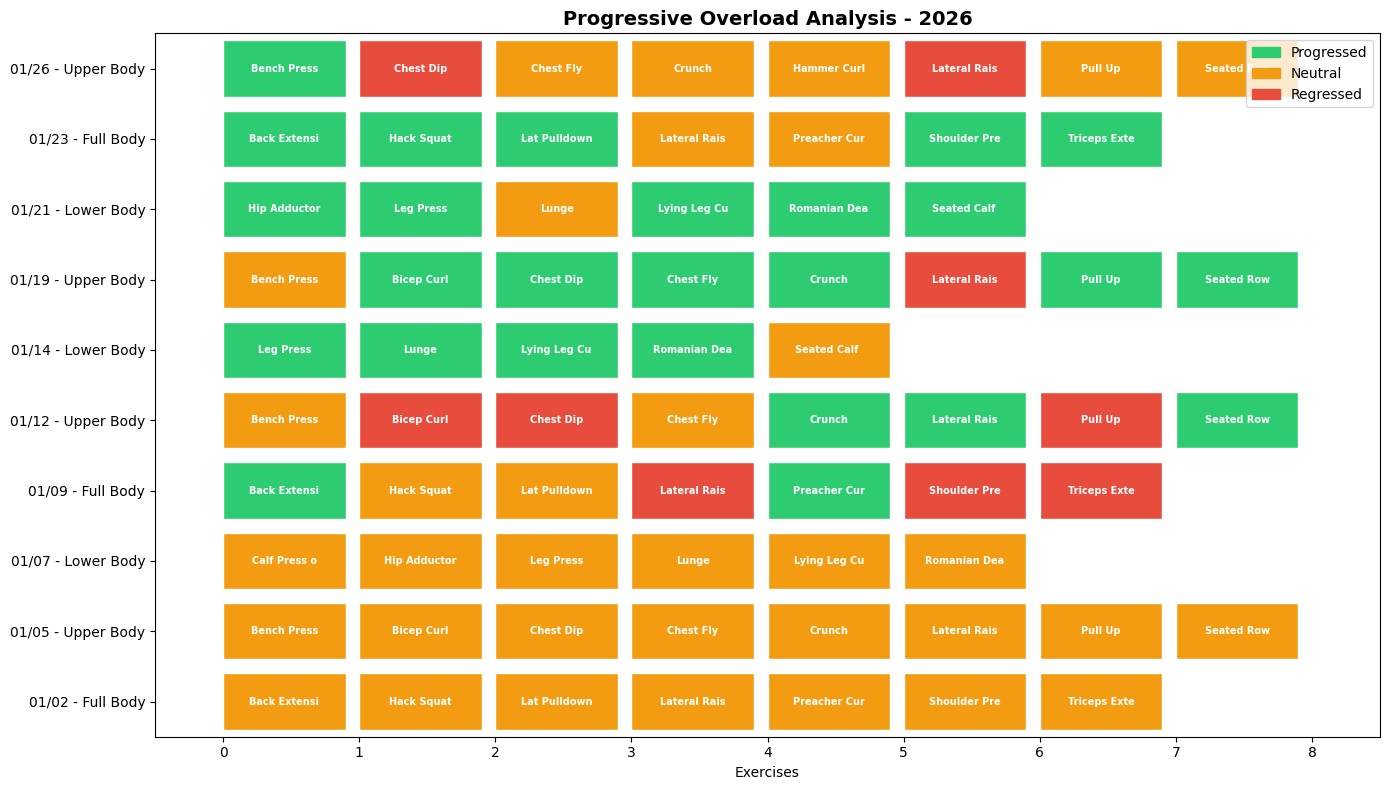

In [8]:
# Create visualization
COLOR_MAP = {
    'progressed': '#2ecc71',  # green
    'neutral': '#f39c12',     # yellow/orange
    'regressed': '#e74c3c'    # red
}

workouts = exercise_progression.groupby(['Date', 'Workout Name'])
workout_dates = sorted(exercise_progression['Date'].unique())

fig, ax = plt.subplots(figsize=(14, max(8, len(workout_dates) * 0.6)))

y_pos = 0
y_labels = []
y_positions = []

for date in workout_dates:
    workout_data = exercise_progression[exercise_progression['Date'] == date]
    workout_name = workout_data['Workout Name'].iloc[0]
    exercises = workout_data['Exercise Name'].tolist()
    progressions = workout_data['Progression'].tolist()
    
    y_labels.append(f"{date.strftime('%m/%d')} - {workout_name}")
    y_positions.append(y_pos)
    
    for i, (exercise, prog) in enumerate(zip(exercises, progressions)):
        color = COLOR_MAP[prog]
        rect = mpatches.Rectangle((i, y_pos - 0.4), 0.9, 0.8, 
                                   facecolor=color, edgecolor='white', linewidth=1)
        ax.add_patch(rect)
        
        # Add exercise name (abbreviated)
        short_name = exercise.split('(')[0].strip()[:12]
        ax.text(i + 0.45, y_pos, short_name, ha='center', va='center', 
                fontsize=7, color='white', fontweight='bold')
    
    y_pos += 1

ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)
ax.set_xlim(-0.5, max(exercise_progression.groupby('Date')['Exercise Name'].count()) + 0.5)
ax.set_ylim(-0.5, y_pos - 0.5)
ax.set_xlabel('Exercises')
ax.set_title('Progressive Overload Analysis - 2026', fontsize=14, fontweight='bold')

# Legend
legend_patches = [
    mpatches.Patch(color=COLOR_MAP['progressed'], label='Progressed'),
    mpatches.Patch(color=COLOR_MAP['neutral'], label='Neutral'),
    mpatches.Patch(color=COLOR_MAP['regressed'], label='Regressed')
]
ax.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()

In [9]:
# Available sessions - pick one by index
sessions = df.groupby(['Date', 'Workout Name']).size().reset_index()[['Date', 'Workout Name']]
for i, (_, row) in enumerate(sessions.iterrows()):
    print(f"{i}: {row['Date'].strftime('%m/%d')} - {row['Workout Name']}")

0: 01/02 - Full Body
1: 01/05 - Upper Body
2: 01/07 - Lower Body
3: 01/09 - Full Body
4: 01/12 - Upper Body
5: 01/14 - Lower Body
6: 01/19 - Upper Body
7: 01/21 - Lower Body
8: 01/23 - Full Body
9: 01/26 - Upper Body


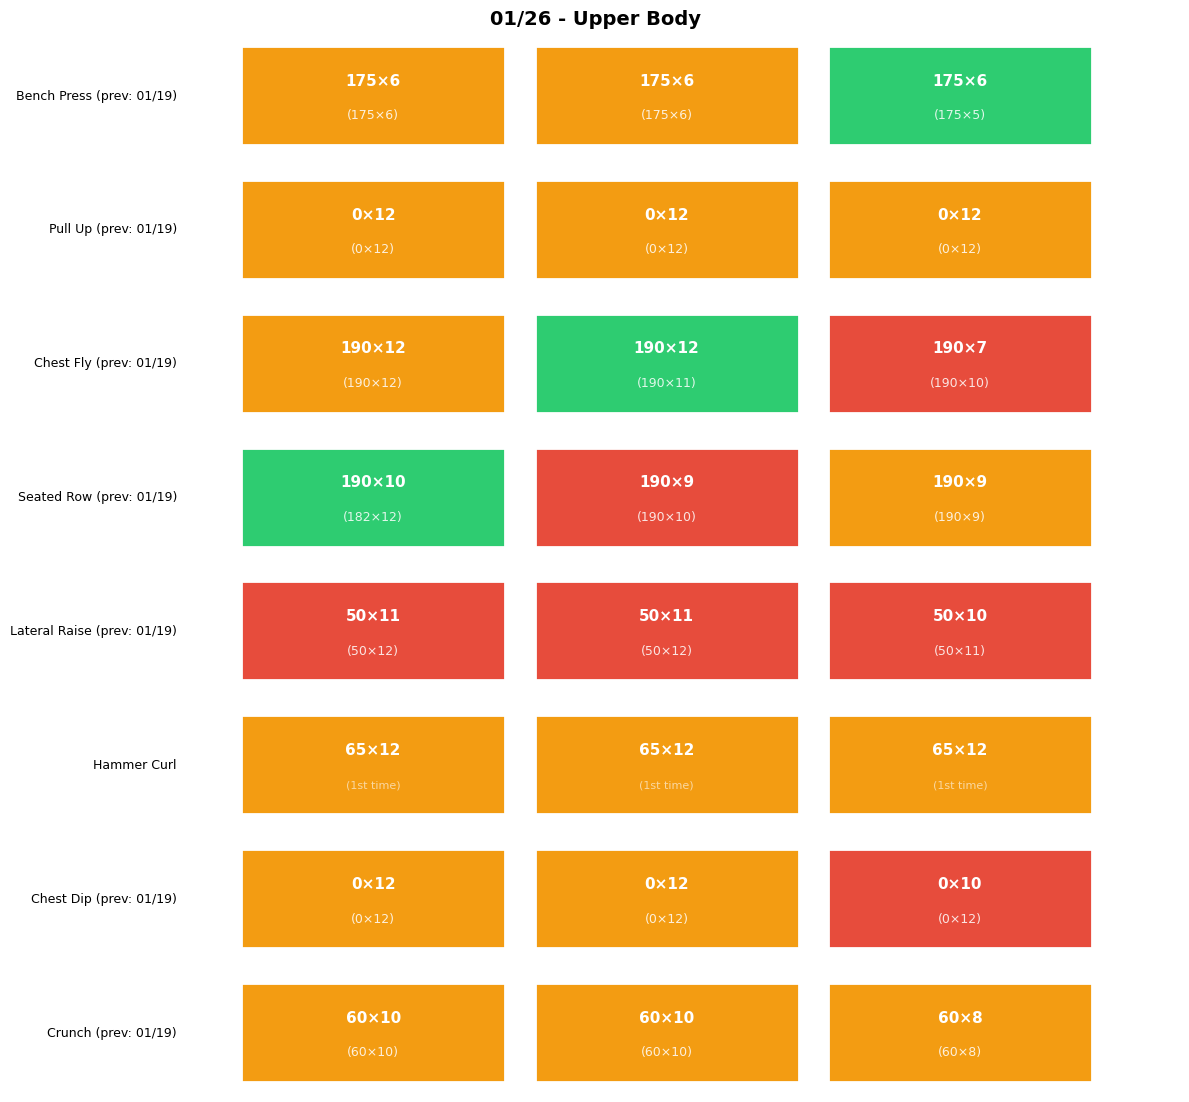

In [12]:
# Change this to select a session
SESSION_INDEX = -1  # <- change this. Setting to -1 gives us latest session.

session_row = sessions.iloc[SESSION_INDEX]
date = session_row['Date']
session_df = df[df['Date'] == date].copy()
workout_name = session_df['Workout Name'].iloc[0]

exercises = session_df['Exercise Name'].unique()
n_exercises = len(exercises)

fig, axes = plt.subplots(n_exercises, 1, figsize=(12, n_exercises * 1.4))
if n_exercises == 1:
    axes = [axes]

for ax, exercise in zip(axes, exercises):
    ex_sets = session_df[session_df['Exercise Name'] == exercise].sort_values('Set Order')
    n_sets = len(ex_sets)
    prev_date = get_prev_date_for_exercise(exercise, date)
    
    for i, (_, row) in enumerate(ex_sets.iterrows()):
        set_num = row['Set Order']
        curr_w, curr_r = row['Weight'], row['Reps']
        prog = row['SetProgression']
        
        # Get previous session data
        prev_w, prev_r = None, None
        if prev_date is not None:
            prev_key = (prev_date, exercise, set_num)
            if prev_key in set_lookup:
                prev_w = set_lookup[prev_key]['Weight']
                prev_r = int(set_lookup[prev_key]['Reps'])
        
        color = COLOR_MAP[prog]
        rect = mpatches.Rectangle((i, 0), 0.9, 1, facecolor=color, edgecolor='white', linewidth=2)
        ax.add_patch(rect)
        
        # Current week numbers
        curr_text = f"{int(curr_w)}×{int(curr_r)}"
        ax.text(i + 0.45, 0.65, curr_text, ha='center', va='center', 
                fontsize=11, color='white', fontweight='bold')
        
        # Previous session numbers (smaller, below)
        if prev_w is not None:
            prev_text = f"({int(prev_w)}×{prev_r})"
            ax.text(i + 0.45, 0.3, prev_text, ha='center', va='center',
                    fontsize=9, color='white', alpha=0.85)
        else:
            ax.text(i + 0.45, 0.3, "(1st time)", ha='center', va='center',
                    fontsize=8, color='white', alpha=0.6)
    
    ax.set_xlim(-0.2, n_sets + 0.2)
    ax.set_ylim(-0.1, 1.1)
    
    # Show exercise name and when it was last done
    if prev_date:
        label = f"{exercise.split('(')[0].strip()[:18]} (prev: {prev_date.strftime('%m/%d')})"
    else:
        label = exercise.split('(')[0].strip()[:20]
    ax.set_ylabel(label, fontsize=9, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[:].set_visible(False)

fig.suptitle(f"{date.strftime('%m/%d')} - {workout_name}", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()